In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from simulator import Simulator
from tools_analysis import corrcoef, coef_var
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, set_style, despine, add_caption
import copy
from IPython.display import display

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from tqdm import tqdm_notebook as tqdm
import pathlib
from causal_optoconnectics.core import hit_rate

In [27]:
plt.rcParams['figure.figsize'] = (16,9)

In [117]:
# p = pathlib.Path('../cluster/results/')
path = pathlib.Path('../cluster/no_stim_in_eq/')

In [118]:
spikes_ex, spikes_in = [], []
for f in path.iterdir():
    if f.suffix == '.gdf':
        df = pd.read_csv(
            f, sep='\t', header=None).rename(columns={0:'sender', 1:'times'}).drop(columns=2)
        if f.stem.startswith('ex'):
            spikes_ex.append(df)
        else:
            spikes_in.append(df)
            
spikes_ex = pd.concat(spikes_ex)
spikes_in = pd.concat(spikes_in)

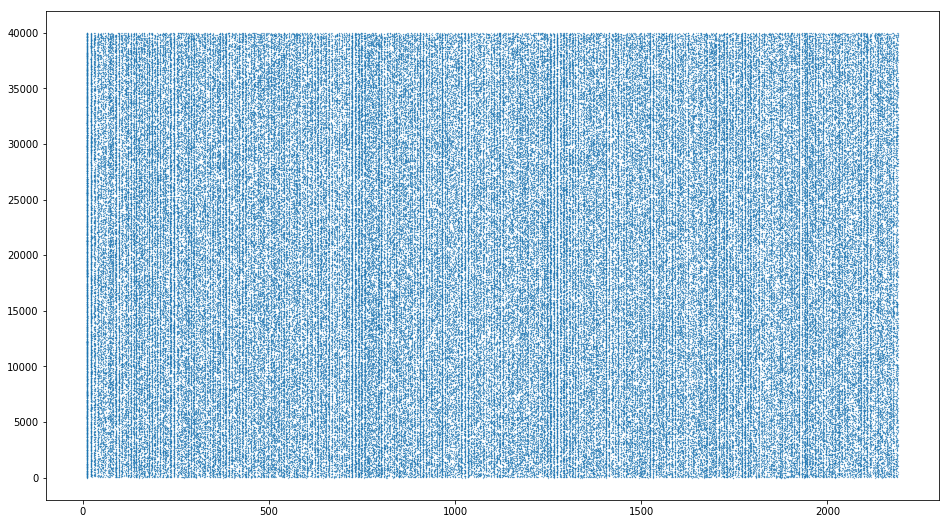

In [133]:
plt.scatter(spikes_ex.times, spikes_ex.sender, s=.05)

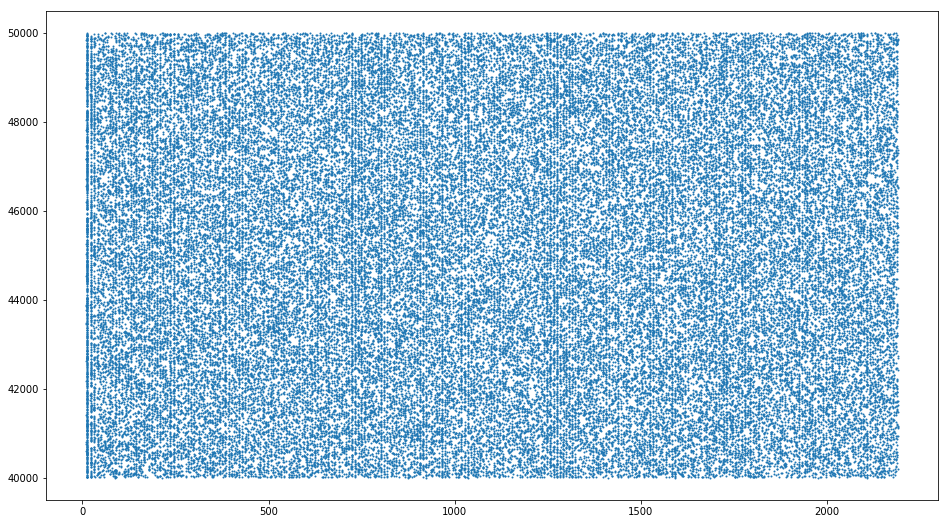

In [120]:
plt.scatter(spikes_in.times, spikes_in.sender, s=1)

In [121]:
spiketrains_ex = spikes_ex.groupby('sender')
spiketrains_in = spikes_in.groupby('sender')

In [122]:
import json
with open(str(path / 'params.json'), 'r') as f:
    params = json.load(f)

t_stop = params['status']['time']

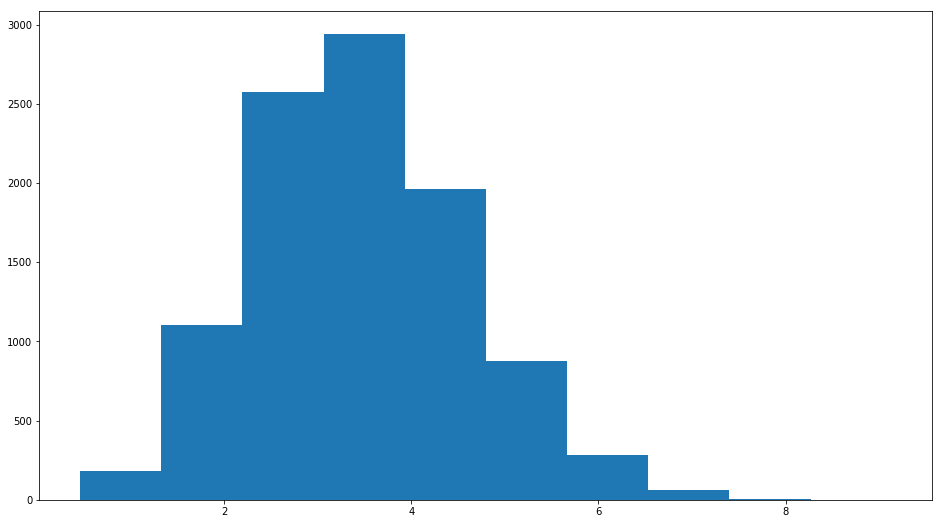

In [123]:
plt.hist([len(s.times) / (t_stop / 1000) for i, s in spiketrains_in]);

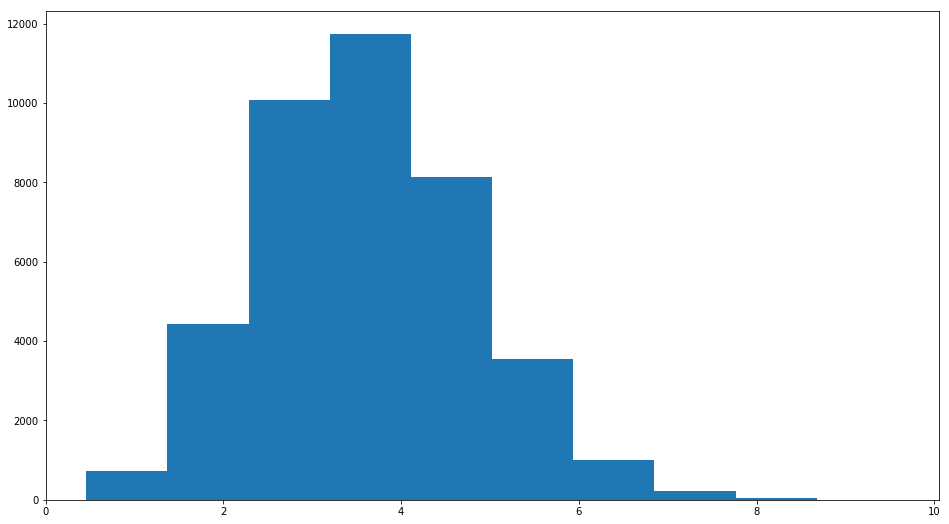

In [124]:
plt.hist([len(s.times) / (t_stop / 1000) for i, s in spiketrains_ex]);

../tools_analysis.py:73: RuntimeWarning: invalid value encountered in true_divide
  mat = [(m - m.mean()) / m.std() for m in [a, b]]


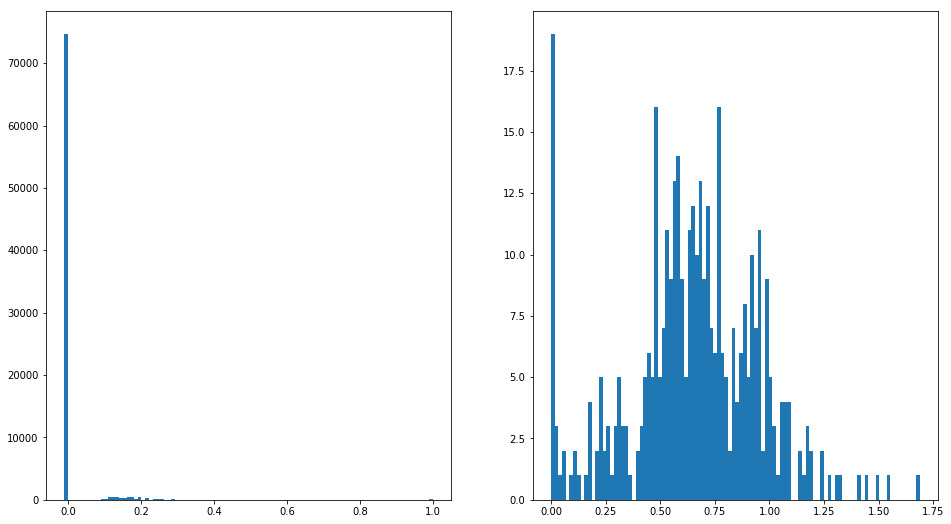

In [134]:
fig, ax = plt.subplots(1, 2)


binsize_corr = 2.
spiketrains_list = [
    s.times[s.times > 500] for i, s in spiketrains_ex 
    if (s.sender.iloc[0] > 4000) and s.sender.iloc[0] < 5000]
spiketrains_sampled = [spiketrains_list[i] for i in np.random.randint(0, len(spiketrains_list), 400)]
cc = corrcoef(
    spiketrains_sampled, t_stop, binsize=binsize_corr)

cc = cc[np.triu_indices(len(cc), k=1)]
cc = cc[~np.isnan(cc)]
ax[0].hist(cc, bins=100);


cv = np.array(coef_var(spiketrains_sampled))
cv = cv[~np.isnan(cv)]

ax[1].hist(cv, bins=100);

In [126]:
stim_data = np.load(path / 'stimulation_data.npz', allow_pickle=True)['data'][()]

In [127]:
stim_times = stim_data['epoch']['times']

Text(0.5,0,'Hit rate')

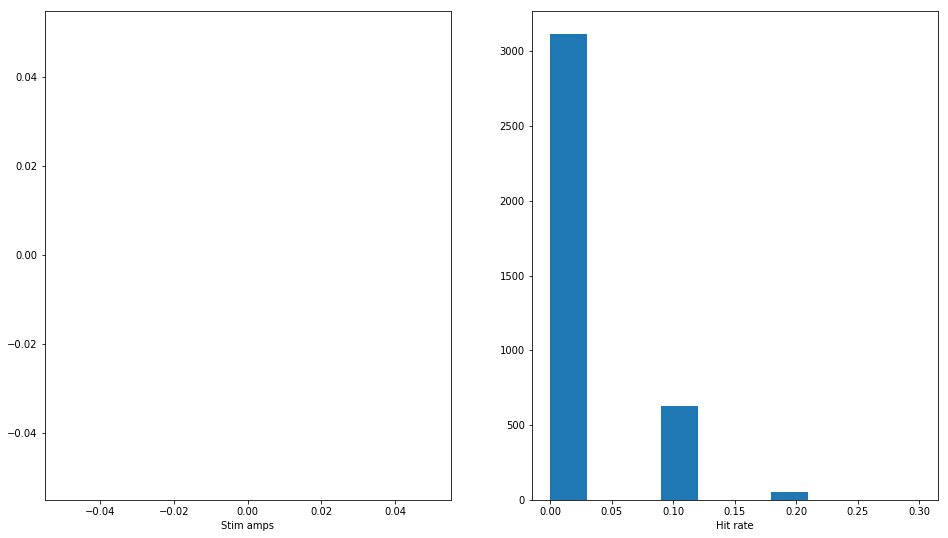

In [129]:
mu = 4
sigma = 3 # not used
hit_rates = [hit_rate(s.times, stim_times,  mu=mu, sigma=sigma)
             for i, s in spiketrains_ex if s.sender.iloc[0] in stim_data['stim_nodes']['ex']]


fig, ax = plt.subplots(1, 2)

amps = np.array(list(stim_data['stim_amps']['ex'].values()))
ax[0].hist(amps, bins=np.unique(amps))
ax[0].set_xlabel('Stim amps')

ax[1].hist(hit_rates)
ax[1].set_xlabel('Hit rate')

In [104]:
p = {
    'stim_N_ex'       : 4000,
    'stim_N_in'       : 0,
    'stim_dist'       : 'poisson',
    'stim_amp_ex'     : 1000.0, # pA
    'stim_amp_in'     : 0.0, # pA
    'stim_rate'       : 30.0,
    'stim_isi_min'    : 200.0, # ms
    'stim_duration'   : 2.0, # ms
    'stop_time'       : 16000, #s
    # Optogenetics
    'I0': 10, # light intensity leaving fibre mW/mm2 DONT ADJUST, USE stim_amp_ex
    'r': 100e-3, # 100 um radius of fiber
    'n': 1.36, # refraction index of gray matter
    'NA': 0.37, # Numerical Aperture of fiber
    'S': 10.3, # mm^-1 scattering index for rat, mouse = 11.2
    'N_pos': 400,
    'depth': .7,
    'Imax': 642, # max current pA
    'K': 0.84, # half-maximal light sensitivity of the ChR2 mW/mm2
    'n_hill': 0.76, # Hill coefficient
}

nodes_ex = np.arange(4000)

def intensity(z):
    rho = p['r'] * np.sqrt((p['n'] / p['NA'])**2 - 1)
    return rho**2 / ((p['S'] * z + 1) * (z + rho)**2)

def affected_neurons(z):
    theta = np.arcsin(p['NA'] / p['n'])
    lcorr = p['r'] / np.tan(theta)
    rad = (z + lcorr) * np.tan(theta)
    A = np.pi * rad**2
    dz = z[1] - z[0]
    dV = A * dz
    density = p['stim_N_ex'] / sum(dV)
    p['density'] = density
    N = dV * density
    return N

def hill(I):
    In = I**p['n_hill']
    return p['Imax'] * In / (p['K']**p['n_hill'] + In) # peak amplitude of the current response

# Set dc stimulation
stims = []
z = np.linspace(0, p['depth'], p['N_pos'])
N_slice = affected_neurons(z).astype(int)

I = intensity(z)
A = hill(p['I0'] * I)
A = A / A.max()
idx = 0
stim_amps_ex = {}
stim_amps_in = {}
stim_nodes_ex = []
stim_nodes_in = []
for i, N_stim in enumerate(N_slice):
    nodes = nodes_ex[idx:idx + N_stim]
    stim_nodes_ex.extend(list(nodes))
    idx += N_stim
    amp = A[i] * p['stim_amp_ex']
    stim_amps_ex.update({n: amp for n in nodes})

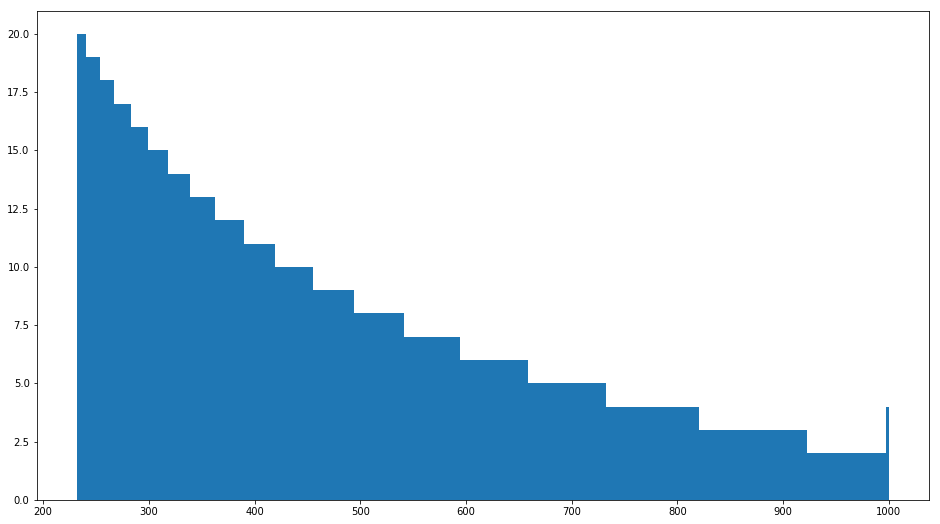

In [105]:
amps = list(stim_amps_ex.values())
amps_u = np.unique(amps)
bins = len(amps_u)#np.arange(min(amps), max(amps), )
plt.hist(amps, bins=amps_u);

In [103]:
amps_u

array([232.19067659, 232.50221449, 232.81429896, 233.12693107,
       233.44011193, 233.75384263, 234.06812427, 234.38295795,
       234.69834478, 235.01428586, 235.3307823 , 235.64783521,
       235.96544569, 236.28361487, 236.60234386, 236.92163378,
       237.24148575, 237.56190089, 237.88288032, 238.20442518,
       238.52653659, 238.84921569, 239.1724636 , 239.49628146,
       239.82067041, 240.14563159, 240.47116615, 240.79727522,
       241.12395995, 241.45122149, 241.77906099, 242.1074796 ,
       242.43647849, 242.7660588 , 243.09622169, 243.42696833,
       243.75829988, 244.09021751, 244.42272238, 244.75581566,
       245.08949853, 245.42377217, 245.75863774, 246.09409642,
       246.43014941, 246.76679787, 247.10404301, 247.44188599,
       247.78032802, 248.11937029, 248.45901399, 248.79926031,
       249.14011046, 249.48156564, 249.82362705, 250.16629589,
       250.50957338, 250.85346071, 251.19795911, 251.54306979,
       251.88879397, 252.23513285, 252.58208767, 252.92